#### 1. 단독다가구

In [430]:
import pandas as pd

target_csv = "../data/Bundang_20251215/실거래_단독다가구_분당구_2015이후.csv"
trade_df = pd.read_csv(target_csv, dtype=str)
trade_df = trade_df[trade_df["거래구분"] == '1']
trade_df

,계약년월,거래구분,번호,계약일,시군구일련번호,번지,주택유형,도로조건,연면적,대지면적,거래금액,월세,건축년도,도로명,해제사유발생일,거래유형,시군구명,법정동코드
10,201501,1,1954,09,2084,1**,다가구,8m미만,417.0000,212.0000,89990.0000,0.0000,1994,발이봉남로16번길,-,NaN,경기도 성남시분당구 수내동,4113510200
22,201501,1,2609,12,3577,5**,단독,8m미만,108.0000,660.0000,90000.0000,0.0000,2003,고기로554번길,-,NaN,경기도 성남시분당구 대장동,4113511600
36,201501,1,3267,14,2084,1**,다가구,25m미만,414.0000,221.0000,89900.0000,0.0000,1996,발이봉북로,-,NaN,경기도 성남시분당구 수내동,4113510200
48,201502,1,7744,28,3675,3**,단독,12m미만,42.0000,75.0000,30000.0000,0.0000,2013,궁내로,-,NaN,경기도 성남시분당구 궁내동,4113511200
50,201501,1,1955,09,3675,3**,단독,8m미만,196.0000,489.0000,121300.0000,0.0000,1952,궁내로,-,NaN,경기도 성남시분당구 궁내동,4113511200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45155,202404,1,1334,10,3016,5**,단독,12m미만,207.7600,232.1000,210000.0000,0.0000,2012,서판교로126번길,-,중개거래,경기도 성남시분당구 판교동,4113510800
45156,202404,1,1675,12,3016,5**,단독,12m미만,187.2600,231.1000,266000.0000,0.0000,2010,서판교로32번길,-,중개거래,경기도 성남시분당구 판교동,4113510800
45157,202406,1,3531,04,19041,2*,단독,8m미만,285.7600,790.0000,290000.0000,0.0000,2007,쇳골로,-,중개거래,경기도 성남시 분당구 금곡동,4113511100
45209,202508,1,212,29,19315,5**,단독,8m미만,182.9300,706.0000,226000.0000,0.0000,2001,벌장투리로24번길,-,직거래,경기도 성남시 분당구 대장동,4113511600


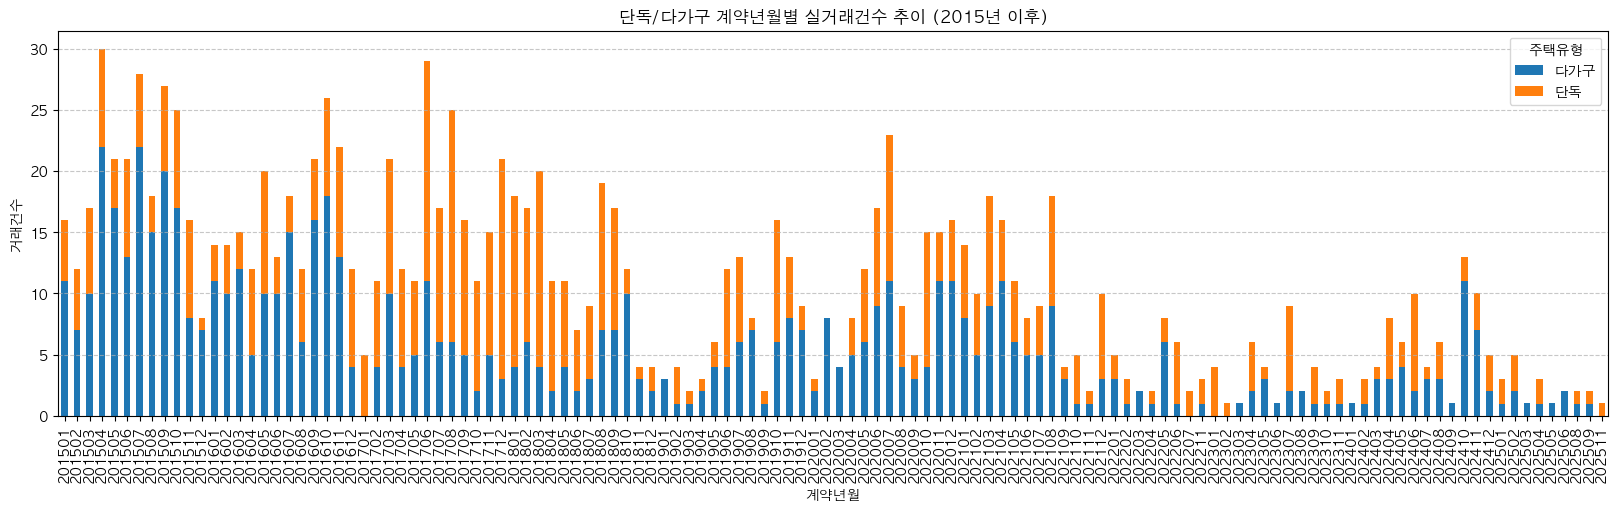

In [426]:
# 실거래 건수 계약년월별 추이 (주택유형 = 다가구/단독)
grouped = (
    trade_df[["계약년월","주택유형"]]
    .groupby(["계약년월","주택유형"])
    .size()
    .reset_index(name="count")
)
pivot_df = (
    grouped
    .pivot(index="계약년월", columns="주택유형", values="count")
    .fillna(0)
)

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False  # 마이너스(-) 깨짐 방지
pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(20,5)
)
plt.xlabel("계약년월")
plt.ylabel("거래건수")
plt.title("단독/다가구 계약년월별 실거래건수 추이 (2015년 이후)")
plt.legend(title="주택유형")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout
plt.show()

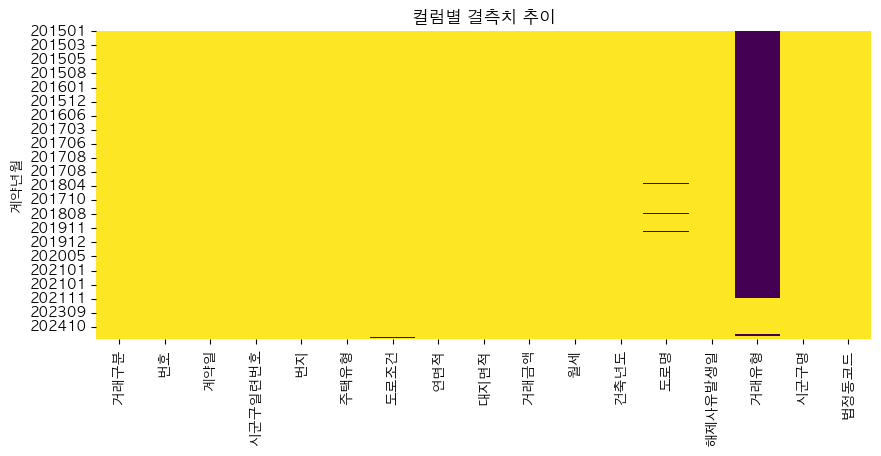

In [427]:
# 결측치 현황
df_heat = trade_df.set_index("계약년월")

na_counts = df_heat.isna().sum()
na_counts

import seaborn as sns
plt.figure(figsize=(10,4))
sns.heatmap(df_heat.isna(), cmap="viridis_r", cbar=False)
plt.title("컬럼별 결측치 추이")
plt.show()

#### <span style="color:yellow">1. 데이터 준비</span>
- 건축물대장의 "표제부"와 "기본개요"을 읽는다.
- "표제부"의 PK를 포함하는 "기본개요"만 남기고 나머지는 필터링.
- "표제부"의 면적정보와 "기본개요"의 주소정보를 조인한다.
- 주소정보로부터 실거래와 조인할 "시군구명"과 "번지"를 만든다.

In [431]:
bldg_base_df = pd.read_csv("../data/Bundang_20251215/건축물대장_기본개요_분당구.csv", dtype=str)
bldg_hdr_df = pd.read_csv("../data/Bundang_20251215/건축물대장_표제부_분당구.csv", dtype=str)

# 표제부(bldg_dr_df)의 PK를 포함하는 기본개요(bldg_base_df)만 필터링
bldg_addr_df = bldg_base_df[bldg_base_df['관리_건축물대장_PK'].isin(bldg_hdr_df['관리_건축물대장_PK'])]

# 표제부와 기본개요를 조인
bldg_df = pd.merge(
            bldg_hdr_df[['관리_건축물대장_PK','대지_면적', '연면적', '주_용도_코드_명', '기타_용도']], 
            bldg_addr_df[['관리_건축물대장_PK', '대지_위치', '도로명_대지_위치']], 
            on="관리_건축물대장_PK", 
            how="left"
            )

# 번지를 masking할 함수
import re
def mask_addr(addr):
    if not isinstance(addr, str):
        addr = str(addr)

    splitted = addr.split()
    result = splitted[:-1]

    bunji = re.sub(r'[^0-9-]', '', splitted[-1])    # 580-9번지 -> 580-9
    bunji = bunji.split('-')[0]     # 580-9 -> 580

    if len(bunji) == 0:
        masked = splitted[-1]     # 예, 경기도 성남시 분당구 대장동 블록
    elif len(bunji) == 1:
        masked = '*'
    else:
        first_char = bunji[0]
        masked_part = '*' * (len(bunji) - 1)
        masked = first_char + masked_part

    return " ".join(result), masked

# masking 함수를 적용하여 "시군구명"과 "번지" 필드를 생성
bldg_df[["시군구명", "번지"]] = pd.DataFrame(bldg_df["대지_위치"].apply(mask_addr).to_list())

# "대지_면적"과 "연면적" 필드는 float로 변환
bldg_df["대지_면적"] = bldg_df["대지_면적"].astype(float)
bldg_df["연면적"] = bldg_df["연면적"].astype(float)

bldg_df

,관리_건축물대장_PK,대지_면적,연면적,주_용도_코드_명,기타_용도,대지_위치,도로명_대지_위치,시군구명,번지
0,1000000000000000093758,227.6,237.60,단독주택,단독주택,경기도 성남시 분당구 운중동 880-1번지,경기도 성남시 분당구 하오개로401번길 7 (운중동),경기도 성남시 분당구 운중동,8**
1,1000000000000000093789,286.8,421.38,단독주택,단독주택,경기도 성남시 분당구 운중동 995-40번지,경기도 성남시 분당구 산운로185번길 38 (운중동),경기도 성남시 분당구 운중동,9**
2,1000000000000000093843,230.2,286.67,단독주택,단독주택,경기도 성남시 분당구 운중동 1037-7번지,경기도 성남시 분당구 운중로166번길 28-9 (운중동),경기도 성남시 분당구 운중동,1***
3,1000000000000000104456,1462.2,5667.62,업무시설,업무시설(오피스텔),경기도 성남시 분당구 대장동 614-1번지,경기도 성남시 분당구 판교대장로8길 9 (대장동),경기도 성남시 분당구 대장동,6**
4,1000000000000000116430,11500.0,92.79,교육연구시설,교육연구시설(미금초등학교),경기도 성남시 분당구 구미동 68번지,경기도 성남시 분당구 미금로 151 (구미동),경기도 성남시 분당구 구미동,6*
...,...,...,...,...,...,...,...,...,...
13212,10891127106,0.0,127.04,단독주택,주택,경기도 성남시 분당구 야탑동 386-3번지,경기도 성남시 분당구 매화로37번길 13-8 (야탑동),경기도 성남시 분당구 야탑동,3**
13213,10891127107,191.6,181.12,단독주택,단독주택,경기도 성남시 분당구 수내동 98-16번지,경기도 성남시 분당구 발이봉남로8번길 10 (수내동),경기도 성남시 분당구 수내동,9*
13214,10891127108,843.0,4205.87,제1종근린생활시설,근린생활시설,경기도 성남시 분당구 이매동 137-2번지,경기도 성남시 분당구 성남대로779번길 56 (이매동),경기도 성남시 분당구 이매동,1**
13215,10891127109,165.0,327.36,단독주택,다가구주택(3가구),경기도 성남시 분당구 정자동 151-2번지,경기도 성남시 분당구 황새울로12번길 1-4 (정자동),경기도 성남시 분당구 정자동,1**


#### <span style="color:yellow">2. 실거래와 조인</span>

In [432]:
# 실거래가 2025년도
#trade_df = pd.read_csv("../data/Bundang_20251215/실거래_단독다가구_분당구_2015이후.csv", dtype=str)
trade_df["실거래ID"] = trade_df.index
trade_202501_df = trade_df[trade_df["계약년월"].str.startswith("202501")]
trade_202501_df

,계약년월,거래구분,번호,계약일,시군구일련번호,번지,주택유형,도로조건,연면적,대지면적,거래금액,월세,건축년도,도로명,해제사유발생일,거래유형,시군구명,법정동코드,실거래ID
40427,202501,1,1311,13,18828,3**,다가구,12m미만,438.0000,231.2000,145000.0000,0.0000,1994,매화로55번길,-,중개거래,경기도 성남시 분당구 야탑동,4113510700,40427
40724,202501,1,470,22,18986,9**,단독,8m미만,397.6000,330.0000,560000.0000,0.0000,2012,산운로,-,중개거래,경기도 성남시 분당구 운중동,4113511500,40724
40725,202501,1,653,21,18986,1***,단독,12m미만,297.9700,268.5000,339000.0000,0.0000,2010,판교원로153번길,-,중개거래,경기도 성남시 분당구 운중동,4113511500,40725


In [433]:
# 시군구 + 번지(마스크된)으로만 조인
all_df = pd.merge(
            trade_202501_df, 
            bldg_df, 
            on=["시군구명", "번지"], 
            how="left").sort_values(["실거래ID"])

# 도로명이 일치하는 건만
all_df = all_df[all_df.apply(lambda row: str(row["도로명"]) in str(row["도로명_대지_위치"]), axis=1)]

# 건물.주용도 != '단독주택'인 경우 필터링
all_df = all_df[(all_df['주_용도_코드_명'] == '단독주택')]

# CSV 파일 저장
all_df.to_csv("all_df.csv", index=False)

temp_df = all_df[['실거래ID', '주택유형', '대지_위치']].groupby(['실거래ID', '주택유형']).count()
temp_df.groupby(['주택유형']).aggregate(['mean'])

,대지_위치
,mean
주택유형,
다가구,9.0
단독,120.0


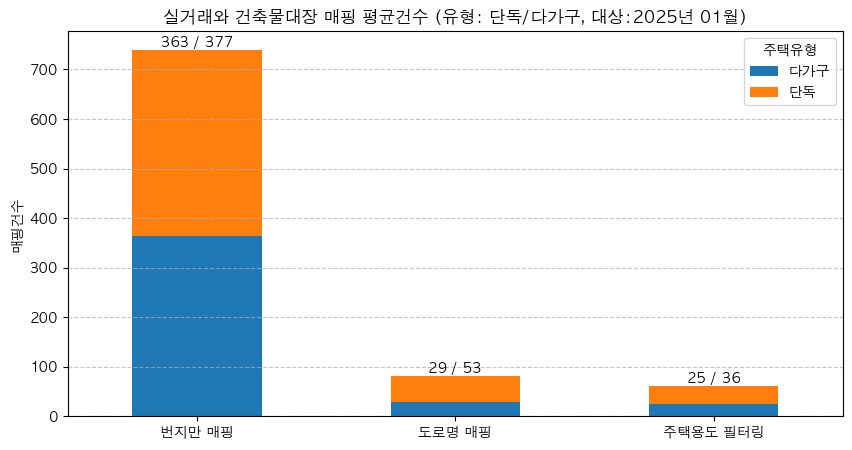

In [434]:
import pandas as pd
df = pd.DataFrame([[363, 377], [29, 53], [25, 36]], columns=["다가구", "단독"], index = ['번지만 매핑', '도로명 매핑', '주택용도 필터링'])


import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False  # 마이너스(-) 깨짐 방지
df.plot(
    kind="bar",
    stacked=True,
    figsize=(10,5)
)
for i in range(len(df)):
    y_pos = df.iloc[i]['다가구'] + df.iloc[i]['단독']
    text = f"{df.iloc[i]['다가구']} / {df.iloc[i]['단독']}"
    plt.text(
        i,
        y_pos,
        str(text),
        ha='center',
        va='bottom',
        fontweight='bold'
    )

#plt.xlabel("매핑방법")
plt.ylabel("매핑건수")
plt.title("실거래와 건축물대장 매핑 평균건수 (유형: 단독/다가구, 대상:2025년 01월)")
plt.legend(title="주택유형")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout
plt.show()

In [422]:
f"{df.iloc[0]['다가구']} / {df.iloc[0]['단독']}"

'363 / 377'

In [399]:
all_df = pd.read_csv("all_df.csv")
all_df[['번호','주택유형','시군구명','번지','거래금액','연면적_x','대지면적','관리_건축물대장_PK','대지_위치','대지_면적','연면적_y','주_용도_코드_명','기타_용도']][all_df['번호']==5366]

,번호,주택유형,시군구명,번지,거래금액,연면적_x,대지면적,관리_건축물대장_PK,대지_위치,대지_면적,연면적_y,주_용도_코드_명,기타_용도
0,5366,다가구,경기도 성남시 분당구 정자동,4*,18000.0,102.65,0.0,10891125000,경기도 성남시 분당구 정자동 44-5번지,206.5,387.79,단독주택,다가구주택 및 근린생활시설
1,5366,다가구,경기도 성남시 분당구 정자동,4*,18000.0,102.65,0.0,10891124971,경기도 성남시 분당구 정자동 43-4번지,231.0,428.92,단독주택,단독주택(3가구)
2,5366,다가구,경기도 성남시 분당구 정자동,4*,18000.0,102.65,0.0,10891125261,경기도 성남시 분당구 정자동 41-10번지,233.7,462.12,단독주택,다가구주택및근린생활시설
3,5366,다가구,경기도 성남시 분당구 정자동,4*,18000.0,102.65,0.0,10891124256,경기도 성남시 분당구 정자동 43-6번지,230.2,433.68,단독주택,다가구주택및근린생활시설
4,5366,다가구,경기도 성남시 분당구 정자동,4*,18000.0,102.65,0.0,10891125307,경기도 성남시 분당구 정자동 42-8번지,206.7,412.24,단독주택,다가구용단독주택
5,5366,다가구,경기도 성남시 분당구 정자동,4*,18000.0,102.65,0.0,10891126594,경기도 성남시 분당구 정자동 44-4번지,230.5,456.96,단독주택,다가구주택 및 근린생활시설
6,5366,다가구,경기도 성남시 분당구 정자동,4*,18000.0,102.65,0.0,10891126359,경기도 성남시 분당구 정자동 45-9번지,231.2,445.68,단독주택,다가구주택 및 근린생활시설
7,5366,다가구,경기도 성남시 분당구 정자동,4*,18000.0,102.65,0.0,10891125369,경기도 성남시 분당구 정자동 44-9번지,230.8,437.44,단독주택,다가구주택 및 근린생활시설
8,5366,다가구,경기도 성남시 분당구 정자동,4*,18000.0,102.65,0.0,10891126321,경기도 성남시 분당구 정자동 45-4번지,233.3,445.46,단독주택,다가구주택 및 근린생활시설
9,5366,다가구,경기도 성남시 분당구 정자동,4*,18000.0,102.65,0.0,10891125904,경기도 성남시 분당구 정자동 41-5번지,210.9,381.76,단독주택,다가구주택및근린생활시설


In [405]:
bldg_floor_df = pd.read_csv("../data/Bundang_20251215/건축물대장_층별개요_분당구.csv", dtype=str)
bldg_floor2_df = pd.read_csv("../data/Bundang_20251215/건축물대장_전유공유면적_분당구.csv", dtype=str)

In [407]:
bldg_floor_df[bldg_floor_df['관리_건축물대장_PK'] == "10891124971"]

,일련번호,관리_건축물대장_PK,층_구분_코드,층_구분_코드_명,층_번호,층_번호_명,구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,면적,주_부속_구분_코드,주_부속_구분_코드_명,면적_제외_여부,생성_일자
48210,9697078,10891124971,10,지하,1,지1,21,철근콘크리트구조,철근콘크리트조,04402,사무소,제2종근린생활시설(사무소),86.850000000,0,주건축물,0,20220909
48211,9697079,10891124971,20,지상,1,1층,21,철근콘크리트구조,철근콘크리트조,01003,다가구주택,단독주택(1가구),99.670000000,0,주건축물,0,20220909
48212,9697080,10891124971,20,지상,2,2층,21,철근콘크리트구조,철근콘크리트조,01003,다가구주택,단독주택(1가구),115.420000000,0,주건축물,NaN,20220909
48213,9697081,10891124971,20,지상,3,3층,21,철근콘크리트구조,철근콘크리트조,01003,다가구주택,단독주택(1가구),115.420000000,0,주건축물,NaN,20220909
48214,9697082,10891124971,10,지하,1,지1,21,철근콘크리트구조,철근콘크리트조,01003,다가구주택,물탱크실,11.550000000,0,주건축물,0,20220909
